## IMPORTING PACKAGES

In [1]:
#Imports
#Packages for numerics + dataframes
import numpy as np
import pandas as pd

#Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Packages for machine learning models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

## EXPLORATORY DATA ANALYSIS

In [2]:
#Loading dataframe
df = pd.read_csv("12.1 price train.csv")
test_df = pd.read_csv("12.2 price test.csv")

#EDA
print('''DATA EXPLORATION
Shape Of Dataframe: {}
Shape of Dataframe Post-Depulication: {}
Size of Dataframe: ({})
Total Count Of Missing Values: ({})'''.
format(df.shape,
       df.drop_duplicates().shape,
       df.size,df.isnull().sum().sum()))

print('\nDATA SUMMARY')
df.info()

print('\nDATA PREVIEW')
df.head()

DATA EXPLORATION
Shape Of Dataframe: (1460, 81)
Shape of Dataframe Post-Depulication: (1460, 81)
Size of Dataframe: (118260)
Total Count Of Missing Values: (7829)

DATA SUMMARY
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Conditi

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## FEATURE ENGINEERING

In [3]:
#Generating function to convert categorical values to numbers
def encode_categorical_values(df, columns):
    for column in columns:
        # Replace NaN/None values with 0
        df[column] = df[column].fillna(0)
        
        # Get unique values, excluding NaN/None (now 0)
        unique_values = df[column].unique()
        
        # Create a value mapping, starting from 1 for non-zero values
        value_mapping = {value: 0 if value == 0 else i + 1 for i, value in enumerate(unique_values) if value != 0}
        value_mapping[0] = 0  # Ensure 0 is mapped to 0
        
        # Map the values
        df[column] = df[column].map(value_mapping)
    
    return df

In [4]:
#Designating columns to encode
columns_to_encode = df.select_dtypes(include=['object']).columns

#Applying encoding function to datasets
df = encode_categorical_values(df, columns_to_encode)
test_df = encode_categorical_values(test_df, columns_to_encode)

#Filling remaining Nan values  
for df_name in [df, test_df]:
    for column in df_name.columns:
        if df_name[column].isnull().any():
            df_name[column] = df_name[column].fillna(df_name[column].mean())

#Generating preview of encoded dataset
df.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,1,65.0,8450,1,0,1,1,1,...,0,0,0,0,0,2,2008,1,1,208500
1,2,20,1,80.0,9600,1,0,1,1,1,...,0,0,0,0,0,5,2007,1,1,181500


In [5]:
#Generating validation algorithm
if len(df.select_dtypes(include=['object']).columns) == 0:
    if df.isna().sum().sum() == 0:
        print("Encoding Success: All Columns With Categorical and NaN Values Encoded \nNaN Filling Success: All NaN Values Filled")
    else:
        na_columns = df.columns[df.isna().any()]
        print("Encoding Error!! : Check Encoding Function \nNaN Filling Error!! : Check Fiiling Algorithm \nColumns With NaN Values")
        for col in na_columns:
            print(f"{col}: {df[col].isna().sum()}")

Encoding Success: All Columns With Categorical and NaN Values Encoded 
NaN Filling Success: All NaN Values Filled


## MODEL PREP

In [6]:
#Defining X and y variables
y = df.SalePrice
X = df.drop(columns=['SalePrice'], axis=1)

#Generating train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=42)

#Generating dataframe for split
split = pd.DataFrame(data={"Dimensions":[X_train.shape, 
                                         X_test.shape, 
                                         y_train.size, 
                                         y_test.size]},
                    index=["X Train", "X Test", "Y Train" ,"Y Test"])

#Previewing split
split

,Dimensions
X Train,"(1168, 80)"
X Test,"(292, 80)"
Y Train,1168
Y Test,292


In [7]:
#Generating empty lists to store results 
Model = []
MAE = []
MSE = []
MPE = []
R2 = []

# Generating function to store and display results
def resultify(name_or_results, test=None, pred=None):
    """
    Processes results if test and pred are provided, 
    or displays results if passed with no additional arguments.
    """
    
    # If called with no test/pred arguments, display the results DataFrame
    if test is None and pred is None:
        return pd.DataFrame(
            data={'MAE': MAE,
                  'MSE': MSE,
                  'MPE': MPE,
                  'R²': R2},
            index=Model
        )
    
    # Ensure all required arguments are provided for result processing
    if not (test is None or pred is None):
        # Generate evaluation scores
        mae_value = mean_absolute_error(pred, test)
        mse_value = np.round(mean_squared_error(pred, test))
        mpe_value = mean_absolute_percentage_error(pred, test)
        r2_value = r2_score(pred, test)

        #Appending values to list
        Model.append(name_or_results)
        MAE.append(mae_value)
        MSE.append(mse_value)
        MPE.append(mpe_value)
        R2.append(r2_value)

## INITIALIZING MODELS

In [8]:
#Initializing first adaboost Regressor
rfr_boost = AdaBoostRegressor(estimator=RandomForestRegressor(),
                              n_estimators=50,
                              learning_rate=1.0,
                              random_state=42).fit(X_train, y_train)

#Initializing second adaboost Regressor
gbr_boost = AdaBoostRegressor(estimator=GradientBoostingRegressor(),
                              n_estimators=50,
                              learning_rate=1.0,
                              random_state=42).fit(X_train, y_train)

#Initializing third adaboost Regressor
xgr_boost = AdaBoostRegressor(estimator=XGBRegressor(),
                              n_estimators=50,
                              learning_rate=1.0,
                              random_state=42).fit(X_train, y_train)

print("ADA BOOSTED REGRESSORS READY")

ADA BOOSTED REGRESSORS READY


## PREDICTIONS

In [9]:
#Generating predictions
rfr_boost_pred = rfr_boost.predict(X_test)
resultify("BOOST RANDOM FOREST", y_test, rfr_boost_pred) #Applying resultify

#Generating predictions
gbr_boost_pred = gbr_boost.predict(X_test)
resultify("BOOST GRADIENT BOOSTING", y_test, gbr_boost_pred) #Applying resultify

#Generating predictions
xgr_boost_pred = xgr_boost.predict(X_test)
resultify("BOOST X GRADIENT BOOSTING", y_test, xgr_boost_pred) #Applying resultify

In [10]:
#Displaying results
resultify('results')

,MAE,MSE,MPE,R²
BOOST RANDOM FOREST,16481.799281,748898123.0,0.090703,0.865105
BOOST GRADIENT BOOSTING,18049.904743,808275129.0,0.098866,0.867677
BOOST X GRADIENT BOOSTING,15938.766428,734109206.0,0.086630,0.870763


## REGRESSION PLOT

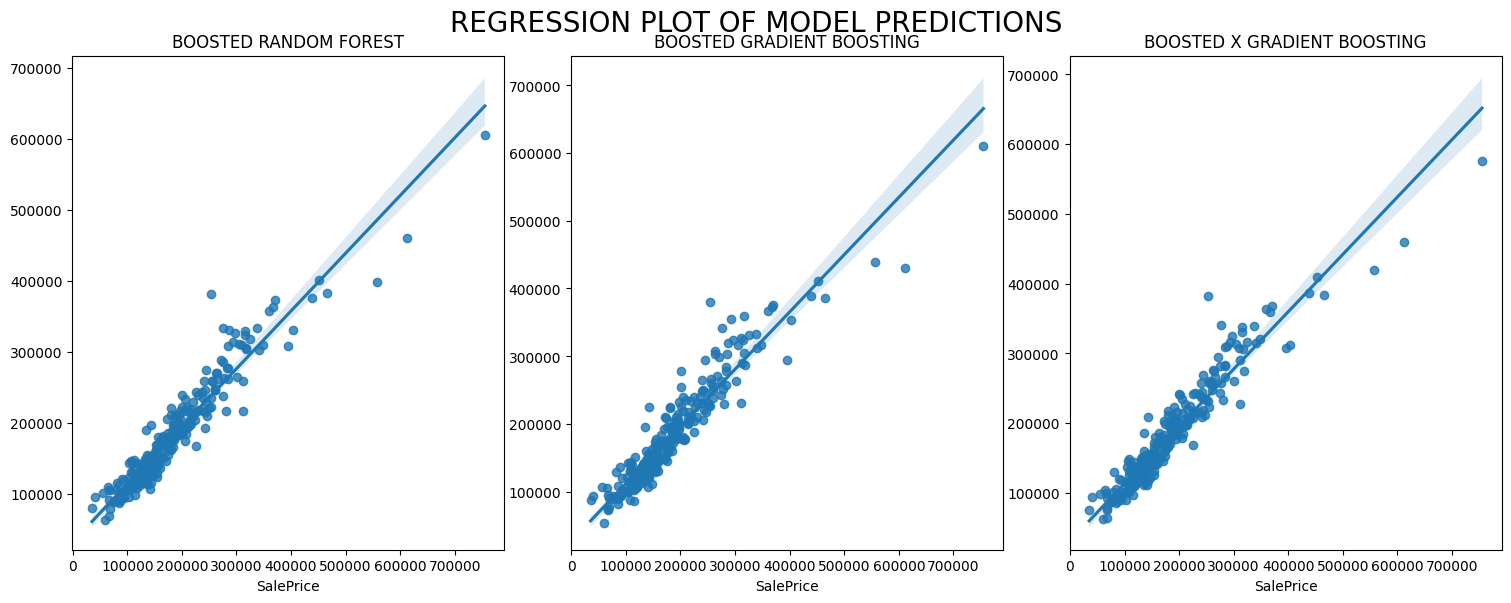

In [11]:
#Generating subplots
fig, ax = plt.subplots(1,3, figsize=(15,6))
plt.suptitle("REGRESSION PLOT OF MODEL PREDICTIONS", fontsize=20)

#Generating Visualizations
sns.regplot(x=y_test, y=rfr_boost_pred, ax=ax[0])
sns.regplot(x=y_test, y=gbr_boost_pred, ax=ax[1])
sns.regplot(x=y_test, y=xgr_boost_pred, ax=ax[2])

#Labelling subplots
ax[0].set_title("BOOSTED RANDOM FOREST")
ax[1].set_title("BOOSTED GRADIENT BOOSTING")
ax[2].set_title("BOOSTED X GRADIENT BOOSTING")
plt.tight_layout(pad=0.3)
plt.show()

## FEATURE IMPORTANCE

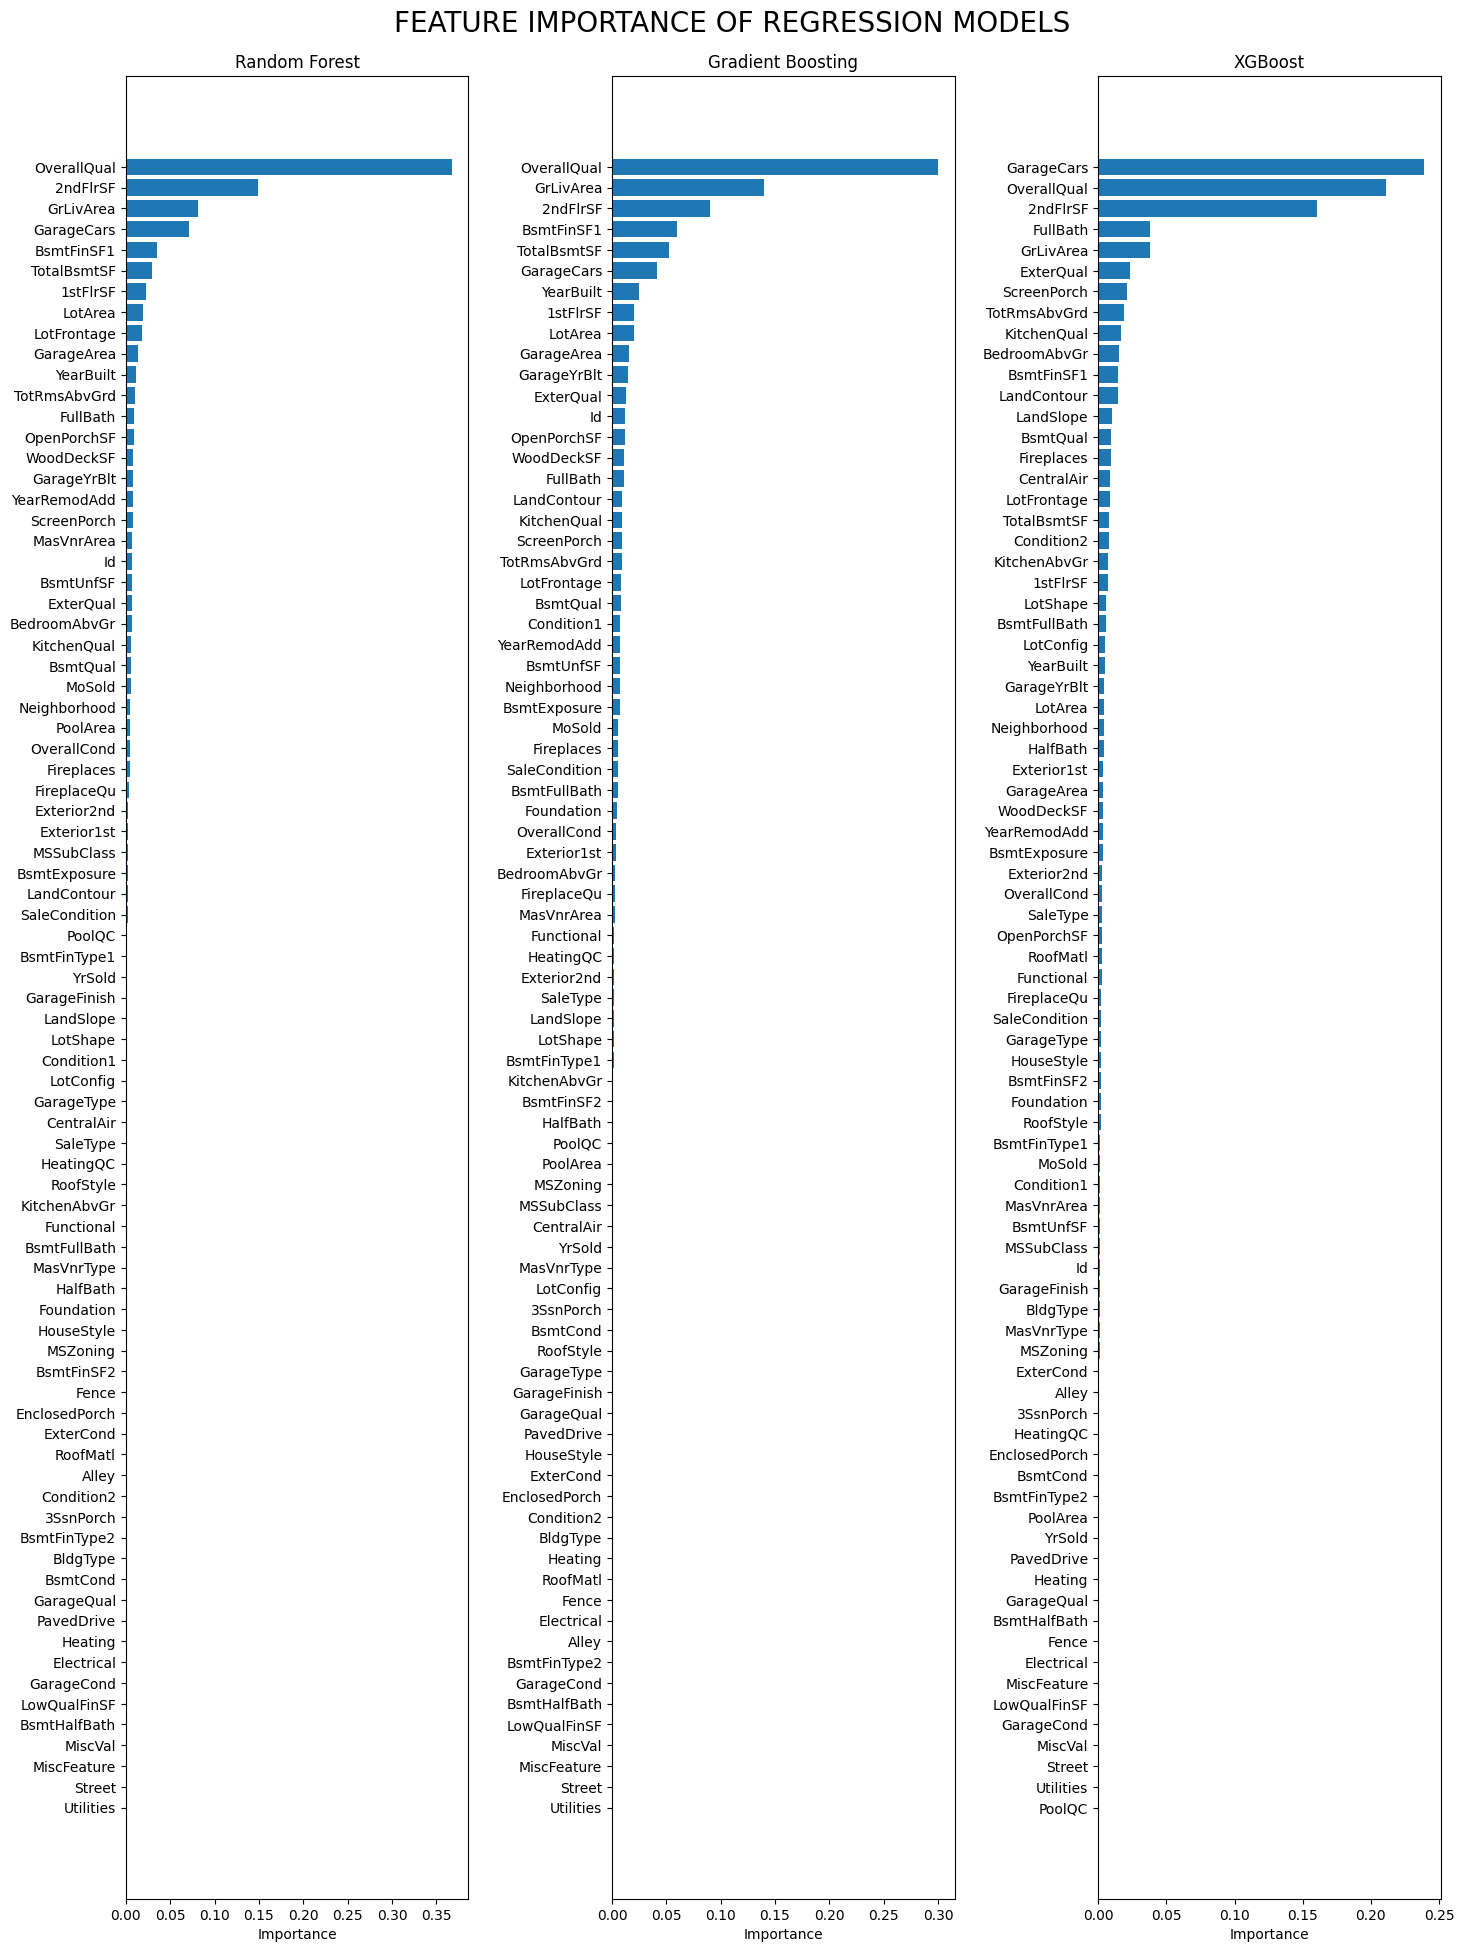

In [12]:
# Get feature importances
rfr_importances = rfr_boost.feature_importances_
gbr_importances = gbr_boost.feature_importances_
xgr_importances = xgr_boost.feature_importances_

# Get feature names
feature_names = X.columns

# Sort feature importances in ascending order
rfr_sorted_idx = np.argsort(rfr_importances)
gbr_sorted_idx = np.argsort(gbr_importances)
xgr_sorted_idx = np.argsort(xgr_importances)

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 20))
plt.suptitle("FEATURE IMPORTANCE OF REGRESSION MODELS", fontsize=20)

# Plot feature importances for RandomForestClassifier
ax[0].barh(feature_names[rfr_sorted_idx], rfr_importances[rfr_sorted_idx])
ax[0].set_title("Random Forest")
ax[0].set_xlabel("Importance")

# Plot feature importances for GradientBoostingClassifier
ax[1].barh(feature_names[gbr_sorted_idx], gbr_importances[gbr_sorted_idx])
ax[1].set_title("Gradient Boosting")
ax[1].set_xlabel("Importance")

# Plot feature importances for XGBClassifier
ax[2].barh(feature_names[xgr_sorted_idx], xgr_importances[xgr_sorted_idx])
ax[2].set_title("XGBoost")
ax[2].set_xlabel("Importance")

plt.tight_layout(pad=2)
plt.show()

## SUBMISSION

In [ ]:
#Generating dataframe for testing data
submission_df = pd.DataFrame(data={'id': np.arange(1461, 2920),
                                   'SalePrice': np.round(xgr_boost.predict(test_df))
                                   })

#Generating submission csv
#submission_df.to_csv('12.3 Submission.csv', index=False)

#Previewing predictions
submission_df.head(5)

,id,SalePrice
0,1461,135732.0
1,1462,165379.0
2,1463,183185.0
3,1464,184956.0
4,1465,194555.0
